In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_no_constraint_illposed import *
# from decentr_quad_no_constraint import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
# problem_spec['vector_size'] = 10
problem_spec['vector_size'] = 50
# problem_spec['sc_theta'] = 1
problem_spec['sc_theta'] = 0.1
problem_spec['sc_perturb'] = True
# problem_spec['sc_index_set'] = {3,4}
problem_spec['sc_index_set'] = {0,1,2,3,4,5}
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()
problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 50, 'sc_theta': 0.1, 'sc_perturb': True, 'sc_index_set': {0, 1, 2, 3, 4, 5}}


In [3]:
Q = problem_data['Q']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']
sc_index_set = problem_spec['sc_index_set']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.average(s), np.min(s)])

[99999999.99999999, 33673795.92173471, 0.010000006957505386]
[99999999.99999994, 33673795.9217347, 0.009999997368803821]
[100000000.00000001, 33673795.9217347, 0.00999999451347196]
[100000000.00000007, 33673795.9217347, 0.009999996890953213]
[100000000.00000009, 33673795.92173472, 0.009999995215706997]
[99999999.99999984, 33673795.9217347, 0.01000000397213237]


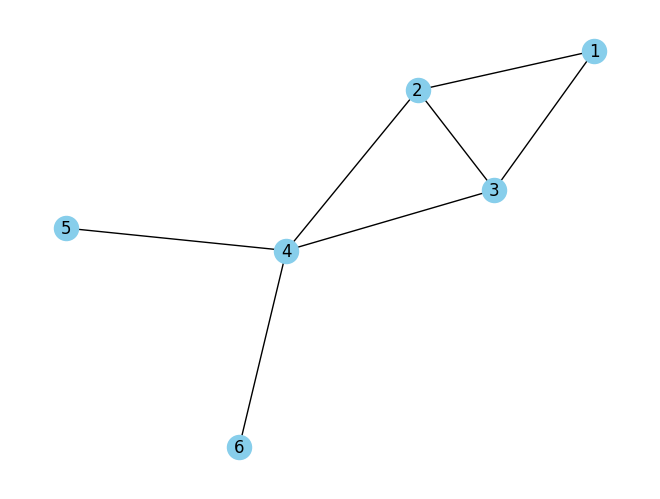

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n6.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.08985702948345038, np.linalg.norm(x_opt_star)=3.3817725206812494e-05


In [6]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.0898570294834504, np.linalg.norm(x_opt_star)=3.3817725206812494e-05


In [7]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj]
    # prox_operators += [lambda z, rho: cvx_prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj) ]
    prox_operators += [lambda z, rho, Qj=Qj, bj=bj, vector_size=vector_size : prox_fj_quad_no_constraint(z, rho, Qj, bj, vector_size) ]
    fi_operators += [lambda x_kj, Qj=Qj, bj=bj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(bj[0], x_kj) ]

    c = np.random.randn(vector_size)
    x1 = prox_operators[-1](c, 1/5)
    x2 = cvx_prox_fj_quad_no_constraint(c, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

In [8]:
best_R = 1
find_best = True

# R = 18
# start, end, space = 0.2, 4, 0.2
# start, end, space = 0.02, 0.4, 0.02
# start, end, space = 0.001, 0.02, 0.001
start, end, space = 0.0001, 0.002, 0.0001


best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        R = round(r, 5)
        # print("Testing R :", r)
        admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=False, freq=200)
        # new_val = sum(admm_f_reldiff[-10:]) / 10
        # new_val = sum(admm_f_reldiff[-300:]) / 300
        # new_val = sum(admm_f_reldiff[-300:-200]) / 100
        new_val = sum(admm_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_R :", round(r, 5),  ", new best_value :", new_val)
            best_value = new_val
            best_R = round(r, 5)

print("best_R :", best_R)

best_R : 1


In [9]:
R = best_R
# R = 3
# R = 2
# R = 1
# R = 0.5
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params={"R":R}, printing=True, freq=200)


ii=0, f_reldiff[-1]=4128402.155092007
ii=200, f_reldiff[-1]=51.11405837445023
ii=400, f_reldiff[-1]=51.10890639862101
ii=600, f_reldiff[-1]=51.100446179382985
ii=800, f_reldiff[-1]=51.08876927385897
ii=999, f_reldiff[-1]=51.074046890680926


In [10]:
# apply P-EXTRA 
best_rho = 1
find_best = True

# problem_data['rho'] = 0.01
# problem_data['rho'] = 0.1
# problem_data['rho'] = 0.2
# problem_data['rho'] = 0.5

# start = 0.2
# start, end, space = 0.1, 2, 0.1
# start, end, space = 0.0005, 0.01, 0.0005
start, end, space = 0.0001, 0.002, 0.0001
# start, end, space = 0.00001, 0.0002, 0.00001

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        problem_data['rho'] = round(r, 5)
        # print("Testing rho :", r)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=False, freq=200)
        # new_val = sum(pg_f_reldiff[-10:]) / 10
        # new_val = sum(pg_f_reldiff[-300:]) / 300
        # new_val = sum(pg_f_reldiff[-300:-200]) / 100
        new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", round(r, 5),  "new best_value :", new_val)
            best_value = new_val
            best_rho = round(r, 5)

print("best_rho :",best_rho)

best_rho : 1


In [11]:
problem_data['rho'] = best_rho
# problem_data['rho'] = 1
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=1657183.874822764, err_opt_reldiff[-1]=0.07336891847185445
ii=200, f_reldiff[-1]=156.59108586297077, err_opt_reldiff[-1]=6.307381125136373e-06
ii=400, f_reldiff[-1]=44.9038602634316, err_opt_reldiff[-1]=3.786714147066243e-06
ii=600, f_reldiff[-1]=44.94993627985671, err_opt_reldiff[-1]=3.780825795937384e-06
ii=800, f_reldiff[-1]=44.99694848783336, err_opt_reldiff[-1]=3.7749566297303224e-06
ii=999, f_reldiff[-1]=45.04335984165475, err_opt_reldiff[-1]=3.76912891582826e-06


In [12]:
# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# params={"R":18, "Inductance":10, "h":1.1054814693822324}
# dadmm_c_all_err_opt_star, dadmm_c_all_err_opt_reldiff, dadmm_c_all_const_vio, dadmm_c_all_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
#                                                                                 network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                                 fi_operators=fi_operators,
#                                                                                 params=params, printing=True, sc_index_set={1,2,3,4,5,6}, freq=200)

In [13]:
# params={"R":0.5, "Inductance":4, "Capacitance":16, "h":2.764408907848405}
# params={"R":1, "Inductance":4, "Capacitance":8, "h":2.764408907848405}
# params={"R":1, "Inductance":4, "Capacitance":4, "h":1.382204453924203}

# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.6540863202464} # worked good for R=3, N(0.5,1)
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.842939271898937} # worked good for R=3, N(0.5,1)



# params={"R":1, "Inductance":6, "Capacitance":8, "h":5.52881781569681} # worked good for Q[j] = Q[j]*50
# params={"R":1, "Inductance":6, "Capacitance":20, "h":5.52881781569681} # worked good for Q[j] = Q[j]*50

# params={"R":1, "Inductance":8, "Capacitance":8, "h":5.5409883749567} # worked good for Q[j] = Q[j]*50

# params={"R":0.5, "Inductance":11, "Capacitance":24, "h":10} # only test
# params={"R":1, "Inductance":6, "Capacitance":8, "h":5.13906193644284} # verified
# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.321989931} # verified
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.6540863202464} # verified


# params={"R":4, "Inductance":2, "Capacitance":2, "h":1} # not verified, but worked well

# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405} # verified


# params={"R":0.5, "Inductance":11, "Capacitance":20, "h":10} # only test
# params={"R":2, "Inductance":3, "Capacitance":4, "h":3.4} # not verified, but worked well for [2.5,3.5]


# params={"R":1.5, "Inductance":4.5, "Capacitance":6, "h":4} # not verified, but worked well

# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.764408907848405} # this also works
# params={"R":2, "Inductance":3, "Capacitance":3, "h":2.764408907848405} # this also works

# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# params={"R":18, "Inductance":10, "h":1.1054814693822324}


# params={"R":3, "Inductance":2, "Capacitance":8/3, "h":1.6540863202464} # fail


# params={"R":0.005, "Inductance":0.005, "Capacitance":400, "h":1} # Same as DADMM
# params={"R":0.007, "Inductance":0.0044, "Capacitance":340, "h":1.2} # works well

# params={"R":0.0003, "Inductance":0.0003, "Capacitance":6666, "h":1} # Same as DADMM
# params={"R":0.0003, "Inductance":0.0003, "Capacitance":6666, "h":1.2} # Work better
# params={"R":0.0004, "Inductance":0.0003, "Capacitance":6666, "h":1.3} # Work better
# params={"R":0.0003, "Inductance":0.0003, "Capacitance":7000, "h":1.2} # Work better # for now best
# params={"R":0.0004, "Inductance":0.0003, "Capacitance":6666, "h":1.3} # Work better



params={"R":0.005, "Inductance":0.005, "Capacitance":400, "h":1} # Same as DADMM

dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff  = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, sc_index_set=sc_index_set, freq=200)

ii=0, f_reldiff[-1]=20949.944906778215
ii=200, f_reldiff[-1]=35.89315108010293
ii=400, f_reldiff[-1]=28.67156315764504
ii=600, f_reldiff[-1]=25.2338268141002
ii=800, f_reldiff[-1]=22.786047026964845
ii=999, f_reldiff[-1]=20.814816957305577


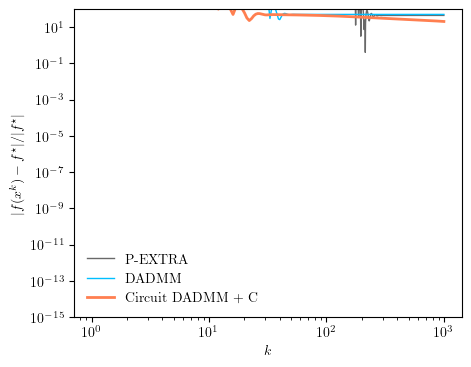

In [14]:
fname = "n6_qp_circuit_dadmm_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'green'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=1)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=1)
# plt.plot(dadmm_c_all_f_reldiff, label='Circuit DADMM + C-All',  color=green, linewidth=1)
plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-15, 1e+2)
# plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)